### 数据库操作
从数据库中导入POI数据

In [144]:
import psycopg2

con = psycopg2.connect(database="prato", user="postgres", password="1218", host="127.0.0.1", port="5432")

# 找出所有含有功能信息的POI
cur = con.cursor()
cur.execute("select * from function where type <> \'null\'")
#cur.execute("select * from function where is_Chinese = True")
rows = cur.fetchall()

print("Database opened successfully")
print("Data Len = ", len(rows))
cur.close()
con.close()

Database opened successfully
Data Len =  10414


### GeoMath
提供坐标与经纬度之间的相互转换

In [2]:
# 基本静态变量
center = [43.878150000000005, 11.083850000000002]
equatorial_radius = 6378137.0
polar_radius = 6356752.3
earth_radius = 6367908.065252312
map_ratio = 0.7211005671900231

# 方法
import math

def calcEarthRadius(lat):
    global earth_radius
    global equatorial_radius
    global polar_radius
    lat = math.radians(lat)
    
    a = equatorial_radius
    b = polar_radius

    ta = a * math.cos(lat)
    tb = b * math.sin(lat)

    earth_radius = math.sqrt((ta * a * ta * a + tb * b * tb * b) / (ta * ta + tb * tb))


def haversineDistance(lat1, lng1, lat2, lng2):
    calcEarthRadius((lat1+lat2)/2)

    dlat = math.radians(lat2 - lat1)
    dlng = math.radians(lng2 - lng1)

    a = math.sin(dlat/2)*math.sin(dlat/2) + math.sin(dlng/2)*math.sin(dlng/2)*math.cos(lat1)*math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))


def latLngToXY(lat, lng):
    global map_ratio
    dist = haversineDistance(lat, lng, center[0], center[1])
    y = math.radians(lat - center[0])
    xp = math.radians(lng - center[1])
    
    if(map_ratio == 0.0):
        yp = math.log(math.tan(math.pi / 4.0 + math.radians(lat) / 2.0)) - math.log(math.tan(math.pi/4.0 + math.radians(center[0]) / 2.0))
        map_ratio = y/yp

    x = map_ratio * xp
    
    return earth_radius * x, earth_radius * y
    

def xyToLatLng(x, y):
    global map_ratio
    lat = math.degrees(y / earth_radius) + center[0]
    x /= map_ratio
    lng = math.degrees(x / earth_radius) + center[1]

    return lat, lng

# 计算地球坐标
calcEarthRadius(center[0])


# 检查经纬度转换是否正确
print(earth_radius)
x, y = latLngToXY(43.831, 11.0202)
print(x, y)
x, y = latLngToXY(43.9253, 11.1475)
print(x, y)

6367908.065252312
-5101.160603307125 -5240.303600544768
5101.146521771683 5240.289134910398


### 数据转换
将数据库中得到的row数据整理为类和对象列表

In [143]:
class Gpoi:
    def __init__(self, placeid, x, y, funtion):
        self.placeid = placeid
        self.x = x
        self.y = y
        self.type = funtion
        
    def __lt__(self, other):
        return self.x < other.x
    

colorDict = {
    'transport': (102, 102, 255),
    'government': (102, 153, 255),
    'health': (102, 204, 255),
    'education': (102, 255, 255),
    'religious': (102, 255, 204),
    'civic': (102, 255, 153),
    'sport': (102, 255, 102),
    'service': (153, 255, 102),
    'beauty': (204, 255, 102),
    'entertain': (255, 255, 102),
    'retail': (255, 204, 102),
    'hotel': (255, 153, 102),
    'food': (255, 102, 102)
}

In [125]:
p = []
for row in rows:
    x, y = latLngToXY(row[1], row[2])
    if('null' in row[7]):
        continue
    p.append(Gpoi(row[0], x, y, row[7]))

p = sorted(p)

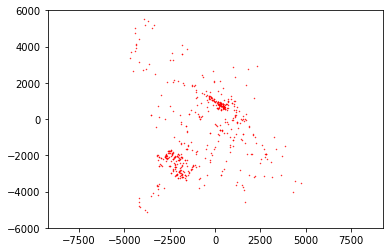

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.array([q.x for q in p])
y = np.array([q.y for q in p])
plt.scatter(x, y, s=0.2, c='r')

plt.axis("equal")
plt.ylim(-6000, 6000)

plt.show()

In [73]:
import bisect
import copy

def rangeAABB(lst, pt, rang):
    tt = copy.deepcopy(pt)
    tt.x -= rang
    left = bisect.bisect_left(lst, tt)
    #print(left)
    tt.x += rang*2
    right = bisect.bisect_left(lst, tt)
    #print(right)
    partP = p[left:right]
    partP.sort(key=lambda p: p.y)
    keys = [p.y for p in partP]
    left = bisect.bisect_left(keys, tt.y-rang)
    right = bisect.bisect_left(keys, tt.y+rang)
    return partP[left:right]


In [91]:
import copy
import bisect

step = 10
num = 9
rang = step*num*3/2

def rangeAABB(pt):
    t = copy.deepcopy(pt)

    ox, oy = t.x, t.y
    t.x -= rang
    left = bisect.bisect_left(p, t)
    t.x += rang*2
    right = bisect.bisect_left(p, t)

    partP = p[left:right]

    ppartP = []
    for q in partP:
        if (q.y < oy+rang and q.y > oy-rang):
            ppartP.append(q)
    
    return ppartP

729


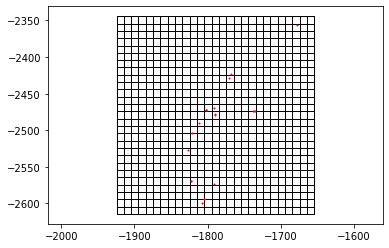

In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

rt = []
lbx, lby = ox-rang, oy-rang

for i in range(27):
    for j in range(27):
        rt.append(Rectangle((lbx+i*step, lby+j*step),10,10))

pc = PatchCollection(rt,facecolors='w', alpha=1,
                         edgecolor='k')

print(len(rt)) 


fig, ax = plt.subplots(1)
ax.add_collection(pc)

ppartP = rangeAABB(p[2213])
x = np.array([q.x for q in ppartP])
y = np.array([q.y for q in ppartP])
ax.scatter(x, y, s=1, c='r')
ax.axis("equal")

plt.show()

In [87]:
import uuid
name = 'name'
namespace = uuid.NAMESPACE_URL


(270, 270, 3)
[[[102 102 255]
  [102 102 255]
  [102 102 255]
  [102 102 255]]

 [[102 102 255]
  [102 102 255]
  [102 102 255]
  [102 102 255]]

 [[102 102 255]
  [102 102 255]
  [102 102 255]
  [102 102 255]]]
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



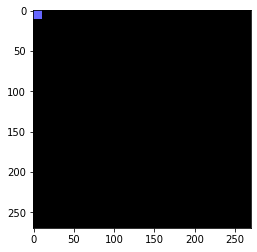

In [142]:
from PIL import Image, ImageDraw

f = Image.new('RGB', (270, 270), (0, 0, 0))

draw = ImageDraw.Draw(f)

draw.rectangle((0, 0, 10, 10), fill=colorDict['transport'])

a = np.asarray(f)[:,:,:]
print(a.shape)
print(a[1:4, 1:5, :])
print(a.flags)
plt.imshow(a)
# f.save('./data/train/{}.jpg'.format(uuid.uuid1()))

In [88]:
print(uuid.uuid3(namespace, name))

739bb330-afe3-33b1-8fb9-2701a8665c68


In [112]:
from time import time
start = time()

ran = 150
step = ran/3*2
index = np.arange(9).reshape(3, 3)

print(len(p))

for t in p:
    partP = []
    bb = [t.x-ran, t.x+ran, t.y-ran, t.y+ran]
    for q in p:
        if()
            partP.append(q)
        # print(len(partP))

print(len(partP))
print("{} seconds".format(str(time() - start)))

10414
204
26.8440260887146 seconds


In [117]:
print(index[1, 1])

4


In [9]:
import numpy as np
a = np.random.randn(3, 3)~
b = np.random.randn(3, 3)
print(a)
print(b)

a = a[np.newaxis, :]
b = b[np.newaxis, :]


[[ 0.92941202 -0.21605436  0.02647636]
 [ 0.45153039 -0.06271475  0.88786447]
 [-1.15372398 -1.86609403 -1.1007605 ]]
[[-0.00854755  1.16653565 -0.13562239]
 [ 0.36311064  0.55410077  0.34260217]
 [ 0.21500937  0.2389833  -1.0079439 ]]


In [12]:
c = np.concatenate((a, b), axis=0)
print(c.shape)

(2, 3, 3)


(1, 1, 3, 3)
